In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
labeled_path = "../data/labels.parquet"

In [9]:
labeled_df = pd.read_parquet(labeled_path)
print(labeled_df.shape)
labeled_df.head()

(31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [7]:
predicted_df = pd.read_parquet('../data/output/xgb.parquet')
predicted_df.tail()

,Location,Date,Predicted_demand
7855,265,2023-04-26,53.553493
7856,265,2023-04-27,76.140839
7857,265,2023-04-28,56.882065
7858,265,2023-04-29,55.795795
7859,265,2023-04-30,55.706608


In [20]:
actual_predicted_df = labeled_df.copy()
actual_predicted_df['Predicted_demand'] = predicted_df['Predicted_demand']
actual_predicted_df.isna().sum()
actual_predicted_df = actual_predicted_df.dropna()

Data General information

Finding Important Locations

In [16]:
def plot_cumsum_demand(labeled_df, target_demand):
    grouped_df = labeled_df.groupby('Location')['Demand'].sum().reset_index().sort_values(by='Demand', ascending=False).reset_index()
    cumulative_demand = (grouped_df['Demand'].cumsum() / grouped_df['Demand'].sum()).to_numpy()

    plt.plot(range(1,263), cumulative_demand)
    plt.xlabel('Location numbers')
    plt.ylabel('Cumulative Demand')
    plt.title('Cumulative Demand by Location')
    target_x = (cumulative_demand <= target_demand).argmin()
    plt.axhline(y=target_demand, color='r', linestyle='--', label=f'Target Demand ({target_demand})')
    plt.axvline(x=target_x, color='g', linestyle='--', label=f'Target Location ({target_x})')

    plt.legend() 
    plt.show()
    important_locations = grouped_df.iloc[:target_x, grouped_df.columns.get_loc('Location')]
    important_locations = important_locations.to_numpy()
    return important_locations

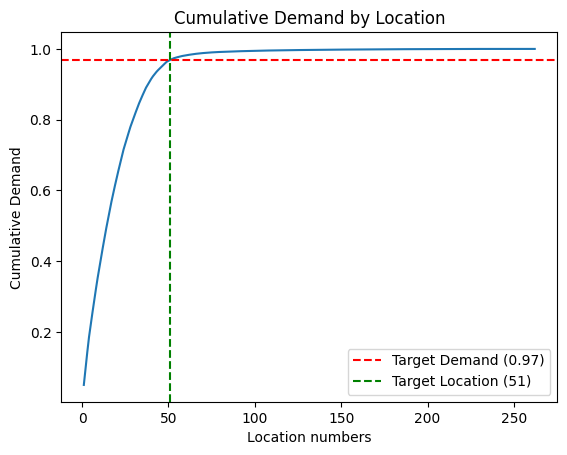

In [21]:
important_locations = plot_cumsum_demand(labeled_df, 0.97)

In [22]:
important_locations

array([132, 237, 161, 236, 162, 186, 230, 142, 138, 170, 163, 239,  48,
       234,  68, 141,  79, 164, 249, 107, 140, 263, 238, 229, 100,  90,
        43, 246, 262, 113, 231, 114, 233, 137, 143, 264, 148, 158, 144,
       151, 211,  50,  75,  13, 125,  87, 166, 261,  70,  24,  88])

In [24]:
high_demand_locations_df = actual_predicted_df\
                                    .loc[actual_predicted_df['Location'].isin(important_locations)]\
                                        .reset_index(drop=True)
high_demand_locations_df

,Location,Date,Demand,Predicted_demand
0,13,2023-01-01,398.0,19.831850
1,13,2023-01-02,381.0,8.803246
2,13,2023-01-03,446.0,21.715181
3,13,2023-01-04,493.0,17.012880
4,13,2023-01-05,614.0,20.243374
...,...,...,...,...
595,50,2023-04-26,646.0,8.982980
596,50,2023-04-27,719.0,5.726442
597,50,2023-04-28,758.0,6.445263
598,50,2023-04-29,785.0,4.814258


In [25]:
low_demand_locations_df = actual_predicted_df\
                                    .loc[~actual_predicted_df['Location'].isin(important_locations)]\
                                        .reset_index(drop=True)
low_demand_locations_df

,Location,Date,Demand,Predicted_demand
0,1,2023-01-01,40.0,9.159037
1,1,2023-01-02,31.0,5.113592
2,1,2023-01-03,27.0,11.624486
3,1,2023-01-04,7.0,9.921972
4,1,2023-01-05,15.0,7.794608
...,...,...,...,...
7255,66,2023-02-25,26.0,53.553493
7256,66,2023-02-26,26.0,76.140839
7257,66,2023-02-27,15.0,56.882065
7258,66,2023-02-28,18.0,55.795795


In [32]:
def calculate_mape(actual_predicted_df:pd.DataFrame):
    
    actual_predicted_df['error'] = (np.abs(actual_predicted_df['Demand']-
                                            actual_predicted_df['Predicted_demand']))*100

    error_per_location = (actual_predicted_df
                                .groupby('Location')
                                .mean())[['Demand', 'Predicted_demand', 'error']]
    error_per_date = (actual_predicted_df
                                .groupby('Date')
                                .mean())[['Demand', 'Predicted_demand', 'error']]
                     
    actual_predicted_df['day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
    error_per_dayofweek = (actual_predicted_df
                                .groupby('day_of_week')
                                .mean())[['Demand', 'Predicted_demand', 'error']]

    return error_per_location, error_per_date, error_per_dayofweek


plot mape

In [33]:

def plot_mape(errors: pd.DataFrame, per):
    errors = errors
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
    errors.plot(y='error', ax=axes, color='red', kind='line', marker='o')
    
    thresholds = pd.DataFrame({'min':[errors['error'].min()], 
                               'mean':[errors['error'].mean()], 
                               'max':[errors['error'].max()]})
    for i, thre in enumerate(thresholds):
            threshold = pd.DataFrame(index=errors.index)
            threshold[str(thresholds.columns[i])] = [thresholds[thre][0]]*len(errors)
            threshold.plot(ax=axes, kind='line', label=str(thre), linestyle='--')
        
    plt.xlabel(str(per))
    title = 'Model Error per ' + str(per) + ' using method ' + str(per)
    plt.title(title)

    plt.show()

In [34]:
error_per_location, error_per_date, error_per_dayofweek = calculate_mape(high_demand_locations_df)

/tmp/ipykernel_54744/1680593516.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_per_location = (actual_predicted_df
/tmp/ipykernel_54744/1680593516.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_per_dayofweek = (actual_predicted_df


In [35]:
error_per_location.shape

(5, 3)

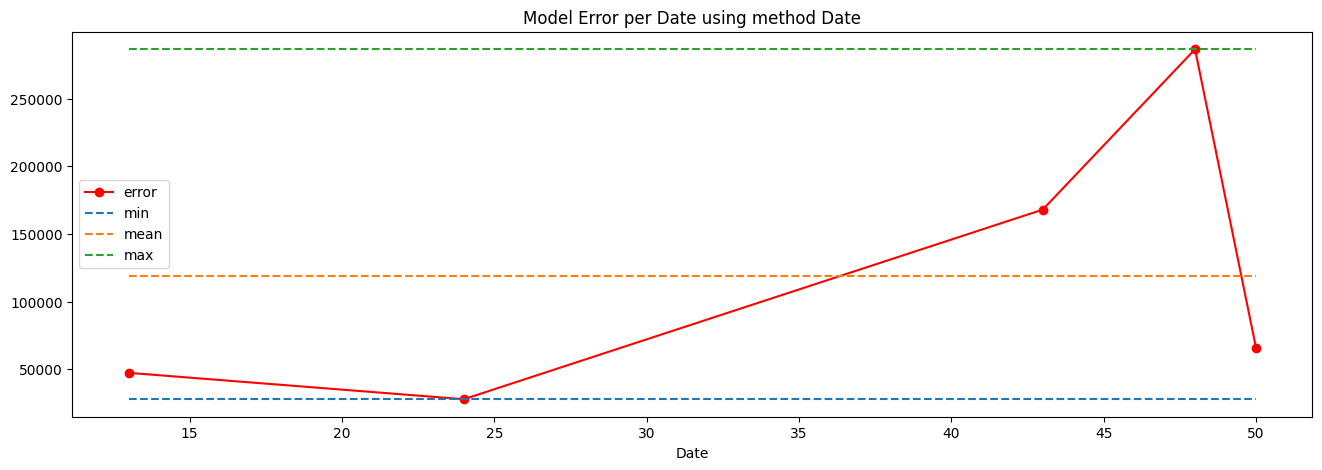

In [36]:
plot_mape(error_per_location, 'Date')


Low Demand Locations Report

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [133]:
def accuracy_per_location(actual_predicted_df: pd.DataFrame):
    # threshold_demand = {}
    num_loc = actual_predicted_df['Location'].unique()
    per_rec_location = pd.DataFrame(columns=['Location','Date', 'Demand', 'Predicted_demand', 'actual_class','predict_class'])
    for loc in num_loc:
        loc_df = actual_predicted_df.loc[actual_predicted_df['Location']==loc]
        loc_mean_demand = loc_df['Demand'].mean()
        loc_df['actual_class'] = loc_df['Demand']-loc_mean_demand
        loc_df['predict_class'] = loc_df['Predicted_demand']-loc_mean_demand
        per_rec_location = pd.concat([per_rec_location,loc_df])
            
    y_test = np.where(per_rec_location['actual_class']>0,1,0)
    y_pred = np.where(per_rec_location['predict_class']>0,1,0)
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    # 
    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    percision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    title = 'Confusion Matrix for low demand locations: \n Precision: '+f'{percision:.2f}'+' Recall: '+f'{recall:.2f}'
    plt.title(title, fontsize=18)
    plt.show()
    
    return per_rec_location
    

/tmp/ipykernel_54744/1126868790.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['actual_class'] = loc_df['Demand']-loc_mean_demand
/tmp/ipykernel_54744/1126868790.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['predict_class'] = loc_df['Predicted_demand']-loc_mean_demand
/tmp/ipykernel_54744/1126868790.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

/tmp/ipykernel_54744/1126868790.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['actual_class'] = loc_df['Demand']-loc_mean_demand
/tmp/ipykernel_54744/1126868790.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['predict_class'] = loc_df['Predicted_demand']-loc_mean_demand
/tmp/ipykernel_54744/1126868790.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

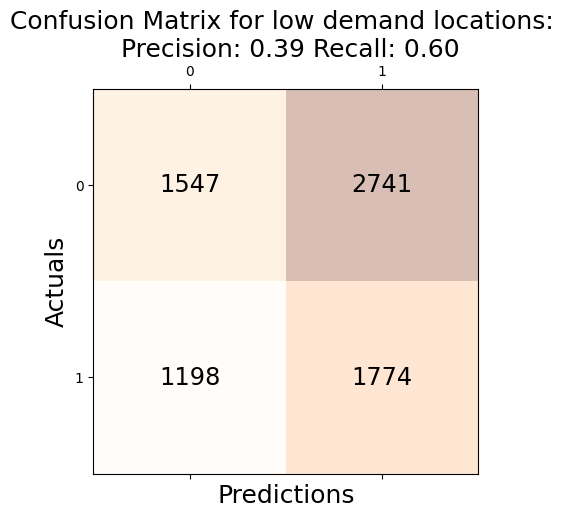

In [134]:
acc_loc_df = accuracy_per_location(low_demand_locations_df)

In [135]:
acc_loc_df.head()

,Location,Date,Demand,Predicted_demand,actual_class,predict_class
0,1,2023-01-01,40.0,9.159037,25.983333,-4.857630
1,1,2023-01-02,31.0,5.113592,16.983333,-8.903074
2,1,2023-01-03,27.0,11.624486,12.983333,-2.392180
3,1,2023-01-04,7.0,9.921972,-7.016667,-4.094694
4,1,2023-01-05,15.0,7.794608,0.983333,-6.222059
